 # Project 7 - Implémentation d'un Modèle de Scoring
 
## Part 4 of 4 - Les importances des Features et le Module SHAP

# 1. Kaggle Resources

**Data:**
* https://www.kaggle.com/c/home-credit-default-risk/data

**Series of Notebooks detailing the Problem:**
* https://www.kaggle.com/willkoehrsen/start-here-a-gentle-introduction
* https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering
* https://www.kaggle.com/willkoehrsen/introduction-to-manual-feature-engineering-p2
* ...

**EDA:**
* https://www.kaggle.com/gpreda/home-credit-default-risk-extensive-eda

**Feature Engineering:**
* https://www.kaggle.com/jsaguiar/lightgbm-with-simple-features

**Models/Scripts - Light_GBM**
* https://www.kaggle.com/tilii7/olivier-lightgbm-parameters-by-bayesian-opt/code
* https://www.kaggle.com/ogrellier/good-fun-with-ligthgbm

**DNN:**
https://www.kaggle.com/shep312/deep-learning-in-tf-with-upsampling-lb-758

# 2. Imports Bibliothèques

In [6]:
import os, re, gc

import pandas as pd
import numpy as np

In [7]:
import sys
import win32com.client 

In [8]:
import shap
import joblib

In [9]:
import matplotlib.pyplot as plt

In [10]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline

# 3. Fonctions

## 3.0 Import des Données

In [11]:
def get_shortcut_path(filepath):
    shell = win32com.client.Dispatch("WScript.Shell")
    shortcut = shell.CreateShortCut(filepath)
    return shortcut.Targetpath +'\\'

## 3.1 Affichage des features importances

In [12]:
def fi_dataframe(coefficients, features):
    fi = pd.DataFrame({'feature' : features, 
                       'importance' :  coefficients, 
                       'strength' :    abs(coefficients)})
    fi_sorted = fi.sort_values(by='strength', ascending=False).reset_index(drop=True)
    # Normalize the feature importances to add up to one
    fi_sorted['importance_norm'] = fi_sorted['importance'] / fi_sorted['importance'].sum()
    fi_sorted['strength_norm'] = fi_sorted['strength'] / fi_sorted['strength'].sum()
    fi_sorted['cumul_importance'] = np.cumsum(fi_sorted['importance_norm'])
    fi_sorted['cumul_strength'] = np.cumsum(fi_sorted['strength_norm'])
    return fi_sorted

In [13]:
def plot_feature_importances(df, num=15, figsize=(10, 6), threshold = 0.9):
    """
    Plot importances returned by a model. This can work with any measure of
    feature importance provided that higher importance is better. 
    

    Args:
        df (dataframe) : contains a columns named 'features' and 'strength_norm'
        
        num (integer): number of top important features to plot
        
        figsize: size of the figures
        
        threshold (float: 0-1.0, default=0.9): Threshold for prining information about cumulative importances

        
    Returns:
        shows a plot of the "num" most importance features,
        prints the number of features needed to reach threshold cumulative importance,
        shows a plot of the cummalative importance

        
        df (dataframe): feature importances sorted by importance (highest to lowest) 
        with a column for normalized importance
        """

    #df = fi_dataframe(coefficients, features)
    
    # Make a horizontal bar chart of feature importances
    plt.figure(figsize = figsize)
    ax = plt.subplot()
    
    # Need to reverse the index to plot most important on top
    ax.barh(list(reversed(list(df.index[:num]))), 
            df['strength_norm'].head(num), 
            align = 'center', edgecolor = 'k')
    
    # Set the yticks and labels
    ax.set_yticks(list(reversed(list(df.index[:num]))))
    ax.set_yticklabels(df['feature'].head(num))
    
    # Plot labeling
    plt.xlabel('Normalized Strength'); plt.title('Feature Strengths')
    plt.show()
    
    # Cumulative importance plot
    plt.figure(figsize = (8, 6))
    plt.plot(list(range(len(df))), df['cumul_strength'], 'r-')
    plt.xlabel('Number of Features'); plt.ylabel('Cumulative Strength'); 
    plt.title('Cumulative Feature Strength');
    plt.show();
    
    importance_index = np.min(np.where(df['cumul_strength'] > threshold))
    print('%d features required for %0.2f of cumulative strength' % (importance_index + 1, threshold))
    
    return df

# 4. Import Données

## 4.1 Les features

In [14]:
PATH = os.path.dirname(os.getcwd())
DATAFOLDER = '\\Data\\'
filepath = PATH + DATAFOLDER
filename = 'features.csv'

features = pd.read_csv(filepath + filename).drop(columns=['Unnamed: 0'])['features'].values

## 4.2 Le data set

### 4.2.1 L dataset entier

In [15]:
PATH = os.getcwd()
DATAFOLDER = '\\DataShortcut.lnk'
filepath = get_shortcut_path(PATH+DATAFOLDER)
filename = 'data_processed.csv'

dataset = pd.read_csv(filepath + filename).drop(columns=['Unnamed: 0'])

In [16]:
y = dataset['TARGET']
client_ids = dataset['SK_ID_CURR']
X = dataset.filter(items=features)
del dataset
gc.collect()

0

### 4.1.2 Le dataset 'min'

In [17]:
PATH = os.path.dirname(os.getcwd())
DATAFOLDER = '\\Data\\'
filepath = PATH + DATAFOLDER
filename = 'data_processed_min.csv'
dataset = pd.read_csv(filepath + filename).drop(columns=['Unnamed: 0'])

y_min = dataset['TARGET']
client_ids_min = dataset['SK_ID_CURR']
X_min = dataset.filter(items=features)
del dataset
gc.collect()

0

### 4.1.2 Le dataset 'min_min'

In [18]:
PATH = os.path.dirname(os.getcwd())
DATAFOLDER = '\\Data\\'
filepath = PATH + DATAFOLDER
filename = 'data_processed_min_min.csv'
dataset = pd.read_csv(filepath + filename).drop(columns=['Unnamed: 0'])

y_min_min = dataset['TARGET']
client_ids_min_min = dataset['SK_ID_CURR']
X_min_min = dataset.filter(items=features)
del dataset
gc.collect()

0

## 4.3 Le preprocesseur

In [19]:
import_model = True
if import_model:
    PATH = os.path.dirname(os.getcwd()) 
    DATAFOLDER = '\\Data\\'
    preprocessor = joblib.load(PATH + DATAFOLDER + 'preprocessor')

In [20]:
preprocessor

ColumnTransformer(transformers=[('zero_one', 'passthrough',
                                 ['APPL_NAME_CONTRACT_TYPE', 'APPL_CODE_GENDER',
                                  'APPL_FLAG_OWN_CAR', 'APPL_FLAG_OWN_REALTY',
                                  'APPL_FLAG_EMP_PHONE', 'APPL_FLAG_WORK_PHONE',
                                  'APPL_FLAG_PHONE', 'APPL_FLAG_EMAIL',
                                  'APPL_REG_REGION_NOT_LIVE_REGION',
                                  'APPL_REG_REGION_NOT_WORK_REGION',
                                  'APPL_LIVE_REGION_NOT_WORK_REGION',
                                  'APPL_REG_CITY_NOT_...
                                  'BURO_DAYS_CREDIT_ENDDATE_MAX',
                                  'BURO_AMT_CREDIT_SUM_DEBT_MAX',
                                  'BURO_AMT_CREDIT_SUM_DEBT_MEAN',
                                  'BURO_AMT_CREDIT_SUM_LIMIT_MEAN',
                                  'BURO_AMT_CREDIT_SUM_LIMIT_SUM',
                            

# 5 LogisticRegression - Version0

## 5.1 Paramètres du Modèle

In [21]:
modelname = 'LogRegr0'

In [22]:
preprocessor_pipeline = Pipeline([
                                  ('preprocessor', MinMaxScaler()),
                                  ('imputer', SimpleImputer()),
                                 ])
model = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l2', C=2, tol=1e-4, warm_start=True)

## 5.2 Import du Modèle

In [23]:
import_model = True
if import_model:
    PATH = os.path.dirname(os.getcwd()) 
    DATAFOLDER = '\\Data\\'
    modelname = modelname
    estimator = joblib.load(PATH + DATAFOLDER + modelname)

## 5.3 Importance des Features - du coefficients

### 5.3.1 Résumé des features importances

In [24]:
features_out = estimator.named_steps.preprocessor.get_feature_names_out()
coefficients = estimator.named_steps.model.coef_[0]

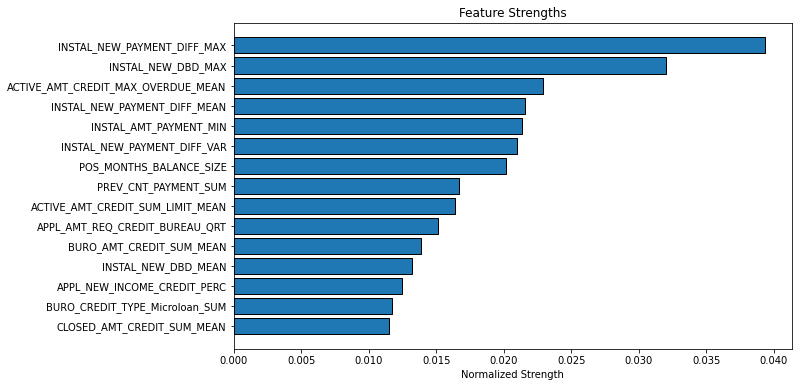

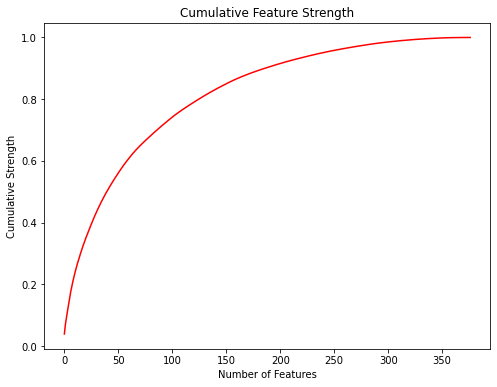

314 features required for 0.99 of cumulative strength


In [25]:
fi_sorted = plot_feature_importances(fi_dataframe(coefficients, features_out), threshold = 0.99)

### 5.3.2 Détails des feature importances

In [26]:
featuretypes = set(f.split('_')[0] for f in features)

In [27]:
featuregroups = []
for featuretype in featuretypes:
    featuregroups.append({'featureytpe' : featuretype, 
                          'strength' : round(100*fi_sorted[fi_sorted['feature'].str.startswith(featuretype)]['strength_norm'].sum(), 2)})
featuregroups = pd.DataFrame(featuregroups).sort_values(by='strength', ascending=False).reset_index(drop=True)
featuregroups

,featureytpe,strength
0,PREV,30.18
1,INSTAL,19.03
2,BURO,15.00
3,APPL,14.13
4,ACTIVE,7.11
5,POS,6.09
6,CLOSED,5.76
7,APPROVED,1.79
8,REFUSED,0.85
9,CREDIT,0.07


In [28]:
new_features = fi_sorted[fi_sorted['feature'].str.contains('_NEW_')]
print('_NEW_', 100 * new_features['strength_norm'].sum())

featuregroups = []
for featuretype in featuretypes:
    featuregroups.append({'featureytpe' : featuretype, 
                          'strength' : round(100*new_features[new_features['feature'].str.startswith(featuretype)]['strength_norm'].sum(), 2)})
featuregroups = pd.DataFrame(featuregroups).sort_values(by='strength', ascending=False).reset_index(drop=True)
featuregroups

_NEW_ 19.624929601530155


,featureytpe,strength
0,INSTAL,15.06
1,APPL,2.63
2,CLOSED,0.92
3,PREV,0.52
4,ACTIVE,0.30
5,BURO,0.11
6,APPROVED,0.07
7,REFUSED,0.00
8,POS,0.00
9,CREDIT,0.00


In [29]:
print('_NEW_', 100 * fi_sorted[fi_sorted['feature'].str.contains('_NEW_')]['strength_norm'].sum())
display(fi_sorted[fi_sorted['feature'].str.contains('_NEW_')][:10])

_NEW_ 19.624929601530155


,feature,importance,strength,importance_norm,strength_norm,cumul_importance,cumul_strength
0,INSTAL_NEW_PAYMENT_DIFF_MAX,11.391759,11.391759,0.832613,0.039340,0.832613,0.039340
1,INSTAL_NEW_DBD_MAX,9.269663,9.269663,0.677511,0.032012,1.510124,0.071352
3,INSTAL_NEW_PAYMENT_DIFF_MEAN,6.252128,6.252128,0.456962,0.021591,2.452322,0.115870
5,INSTAL_NEW_PAYMENT_DIFF_VAR,6.068017,6.068017,0.443506,0.020955,2.444135,0.158167
11,INSTAL_NEW_DBD_MEAN,-3.827106,3.827106,-0.279720,0.013216,1.129134,0.253609
12,APPL_NEW_INCOME_CREDIT_PERC,-3.601112,3.601112,-0.263202,0.012436,0.865932,0.266045
15,INSTAL_NEW_PAYMENT_DIFF_SUM,3.279537,3.279537,0.239698,0.011325,1.110088,0.300599
21,CLOSED_NEW_DURATION_CREDIT_DAYS_MEAN,-2.620403,2.620403,-0.191523,0.009049,0.663918,0.360183
28,APPL_NEW_INCOME_PER_PERSON,2.383218,2.383218,0.174187,0.008230,0.850563,0.420726
45,APPL_NEW_ANNUITY_INCOME_PERC,1.644768,1.644768,0.120215,0.005680,0.893325,0.534116


In [30]:
featuretype = 'APPL'
print(featuretype, 100 * fi_sorted[fi_sorted['feature'].str.startswith(featuretype)]['strength_norm'].sum())
display(fi_sorted[fi_sorted['feature'].str.startswith(featuretype)][:10])

APPL 14.125211831710777


,feature,importance,strength,importance_norm,strength_norm,cumul_importance,cumul_strength
9,APPL_AMT_REQ_CREDIT_BUREAU_QRT,-4.374917,4.374917,-0.319759,0.015108,1.702844,0.226502
12,APPL_NEW_INCOME_CREDIT_PERC,-3.601112,3.601112,-0.263202,0.012436,0.865932,0.266045
28,APPL_NEW_INCOME_PER_PERSON,2.383218,2.383218,0.174187,0.008230,0.850563,0.420726
37,APPL_EXT_SOURCE_3,-1.924909,1.924909,-0.140690,0.006647,0.370693,0.485948
38,APPL_AMT_INCOME_TOTAL,1.918738,1.918738,0.140239,0.006626,0.510931,0.492574
43,APPL_EXT_SOURCE_2,-1.696567,1.696567,-0.124001,0.005859,0.649795,0.522609
45,APPL_NEW_ANNUITY_INCOME_PERC,1.644768,1.644768,0.120215,0.005680,0.893325,0.534116
57,APPL_AMT_ANNUITY,1.359190,1.359190,0.099342,0.004694,0.649886,0.596084
63,APPL_EXT_SOURCE_1,-1.213279,1.213279,-0.088677,0.004190,0.651986,0.622391
70,APPL_DAYS_EMPLOYED,1.034798,1.034798,0.075632,0.003574,0.739183,0.648990


In [31]:
featuretype = 'INSTAL'
print(featuretype, 100 * fi_sorted[fi_sorted['feature'].str.startswith(featuretype)]['strength_norm'].sum())
display(fi_sorted[fi_sorted['feature'].str.startswith(featuretype)][:10])

INSTAL 19.031878162401892


,feature,importance,strength,importance_norm,strength_norm,cumul_importance,cumul_strength
0,INSTAL_NEW_PAYMENT_DIFF_MAX,11.391759,11.391759,0.832613,0.039340,0.832613,0.039340
1,INSTAL_NEW_DBD_MAX,9.269663,9.269663,0.677511,0.032012,1.510124,0.071352
3,INSTAL_NEW_PAYMENT_DIFF_MEAN,6.252128,6.252128,0.456962,0.021591,2.452322,0.115870
4,INSTAL_AMT_PAYMENT_MIN,-6.180028,6.180028,-0.451692,0.021342,2.000630,0.137212
5,INSTAL_NEW_PAYMENT_DIFF_VAR,6.068017,6.068017,0.443506,0.020955,2.444135,0.158167
11,INSTAL_NEW_DBD_MEAN,-3.827106,3.827106,-0.279720,0.013216,1.129134,0.253609
15,INSTAL_NEW_PAYMENT_DIFF_SUM,3.279537,3.279537,0.239698,0.011325,1.110088,0.300599
18,INSTAL_AMT_INSTALMENT_MEAN,-2.881908,2.881908,-0.210636,0.009952,0.447993,0.331883
80,INSTAL_NEW_DPD_MEAN,0.931663,0.931663,0.068094,0.003217,0.874395,0.682168
85,INSTAL_AMT_INSTALMENT_MAX,0.896413,0.896413,0.065518,0.003096,1.206557,0.697862


# 6. LogisticRegression - Version2

## 6.1 Paramètres du Modèle

In [32]:
modelname = 'LogRegr2_Full_Xtrain'

In [33]:
preprocessor_pipeline = Pipeline([
                                  ('preprocessor', preprocessor),
                                  ('imputer', SimpleImputer()),
                                  ])
model = LogisticRegression(class_weight='balanced', solver='liblinear', penalty='l2', C=0.1, tol=1e-4, warm_start=True)

## 6.2 Import du Modèle

In [34]:
import_model = True
if import_model:
    PATH = os.path.dirname(os.getcwd()) 
    DATAFOLDER = '\\Data\\'
    modelname = modelname
    estimator = joblib.load(PATH + DATAFOLDER + modelname)

## 6.3 Importance des Features - du coefficients

### 6.3.1 Résumé des features importances

In [35]:
features_out = []
for i, transformer in enumerate(estimator.named_steps.preprocessor.transformers) :
    features_out += transformer[2]
coefficients = estimator.named_steps.model.coef_[0]

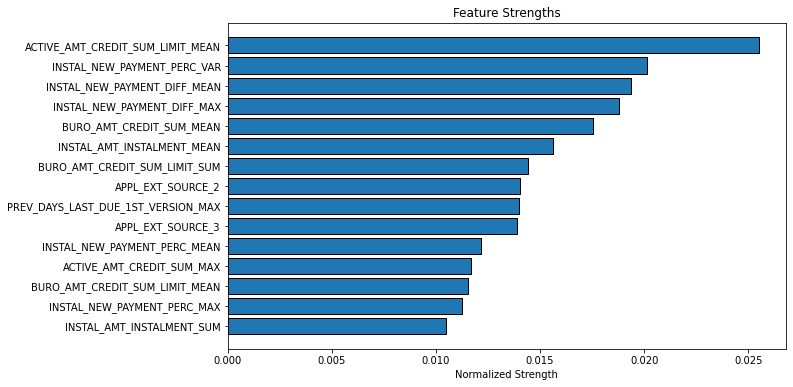

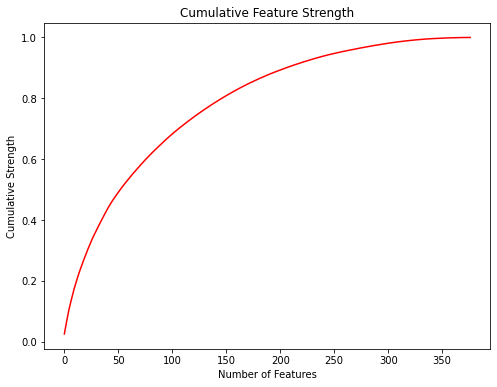

321 features required for 0.99 of cumulative strength


In [67]:
fi_sorted = plot_feature_importances(fi_dataframe(coefficients, features_out), threshold = 0.99)

### 6.3.2 Détails des feature importances

In [50]:
featuretypes = set(f.split('_')[0] for f in features)

In [53]:
featuregroups = []
for featuretype in featuretypes:
    featuregroups.append({'featuretype' : featuretype, 
                          'strength' : round(100*fi_sorted[fi_sorted['feature'].str.startswith(featuretype)]['strength_norm'].sum(), 2)})
featuregroups = pd.DataFrame(featuregroups).sort_values(by='strength', ascending=False).reset_index(drop=True)
featuregroups

,featuretype,strength
0,PREV,31.09
1,APPL,17.38
2,BURO,16.75
3,INSTAL,16.27
4,ACTIVE,6.99
5,CLOSED,4.74
6,POS,4.16
7,APPROVED,2.40
8,REFUSED,0.12
9,CREDIT,0.11


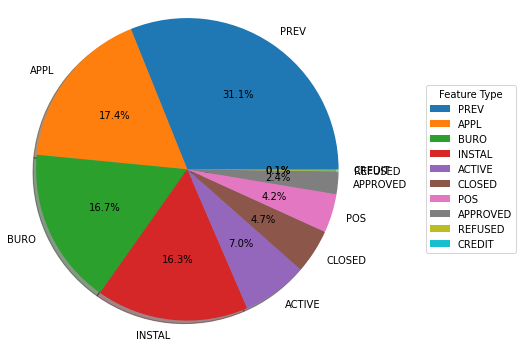

In [59]:
fig1, ax1 = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax1.pie(featuregroups['strength'], labels=featuregroups['featuretype'], autopct='%1.1f%%',
        shadow=True, startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(wedges, featuregroups['featuretype'],
          title="Feature Type",
          loc="center right",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

In [60]:
new_features = fi_sorted[fi_sorted['feature'].str.contains('_NEW_')]
print('_NEW_', 100 * new_features['strength_norm'].sum())

featuregroups = []
for featuretype in featuretypes:
    featuregroups.append({'featureytpe' : featuretype, 
                          'strength' : round(100*new_features[new_features['feature'].str.startswith(featuretype)]['strength_norm'].sum(), 2)})
featuregroups = pd.DataFrame(featuregroups).sort_values(by='strength', ascending=False).reset_index(drop=True)
featuregroups

_NEW_ 15.674118652770423


,featureytpe,strength
0,INSTAL,11.50
1,PREV,1.34
2,APPROVED,0.69
3,BURO,0.66
4,APPL,0.64
5,ACTIVE,0.49
6,CLOSED,0.35
7,REFUSED,0.00
8,POS,0.00
9,CREDIT,0.00


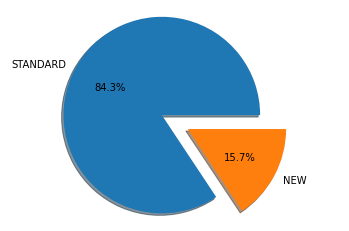

In [66]:
old_features = fi_sorted[~fi_sorted['feature'].str.contains('_NEW_')]
sizes=[old_features['strength_norm'].sum(), new_features['strength_norm'].sum()]
explode = [0, 0.3]
labels = ['STANDARD','NEW']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', normalize=True,
        shadow=True, startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [39]:
print('_NEW_', 100 * fi_sorted[fi_sorted['feature'].str.contains('_NEW_')]['strength_norm'].sum())
display(fi_sorted[fi_sorted['feature'].str.contains('_NEW_')][:10])

_NEW_ 15.674118652770423


,feature,importance,strength,importance_norm,strength_norm,cumul_importance,cumul_strength
1,INSTAL_NEW_PAYMENT_PERC_VAR,2.861519,2.861519,-32.286593,0.020142,8.629171,0.045667
2,INSTAL_NEW_PAYMENT_DIFF_MEAN,2.748265,2.748265,-31.008753,0.019345,-22.379582,0.065011
3,INSTAL_NEW_PAYMENT_DIFF_MAX,2.670667,2.670667,-30.133205,0.018798,-52.512786,0.083810
10,INSTAL_NEW_PAYMENT_PERC_MEAN,-1.728592,1.728592,19.503756,0.012167,65.526123,0.185445
13,INSTAL_NEW_PAYMENT_PERC_MAX,-1.595568,1.595568,18.002833,0.011231,83.277930,0.219862
25,INSTAL_NEW_DBD_MAX,1.165588,1.165588,-13.151355,0.008204,59.228387,0.331121
32,INSTAL_NEW_PAYMENT_DIFF_SUM,0.994125,0.994125,-11.216737,0.006997,49.506088,0.382749
34,APPROVED_NEW_APPL_CREDIT_PERC_VAR,0.983800,0.983800,-11.100243,0.006925,49.559079,0.396632
36,INSTAL_NEW_DBD_MEAN,-0.966130,0.966130,10.900876,0.006800,49.455486,0.410298
52,PREV_NEW_APPL_CREDIT_PERC_MEAN,-0.683944,0.683944,7.716959,0.004814,30.861806,0.501130


In [40]:
featuretype = 'APPL'
print(featuretype, 100 * fi_sorted[fi_sorted['feature'].str.startswith(featuretype)]['strength_norm'].sum())
display(fi_sorted[fi_sorted['feature'].str.startswith(featuretype)][:10])

APPL 17.38181316662512


,feature,importance,strength,importance_norm,strength_norm,cumul_importance,cumul_strength
7,APPL_EXT_SOURCE_2,-1.990800,1.990800,22.462254,0.014013,46.235913,0.145413
9,APPL_EXT_SOURCE_3,-1.969867,1.969867,22.226059,0.013866,46.022368,0.173277
21,APPL_EXT_SOURCE_1,-1.280587,1.280587,14.448896,0.009014,113.845962,0.297048
28,APPL_DAYS_EMPLOYED,1.047293,1.047293,-11.816636,0.007372,48.544282,0.354088
38,APPL_AMT_ANNUITY,0.943571,0.943571,-10.646335,0.006642,28.004911,0.423679
46,APPL_AMT_REQ_CREDIT_BUREAU_QRT,-0.744792,0.744792,8.403506,0.005242,47.072584,0.471213
70,APPL_NAME_EDUCATION_TYPE,-0.567753,0.567753,6.405971,0.003996,31.030945,0.578486
76,APPL_NEW_ANNUITY_INCOME_PERC,0.532004,0.532004,-6.002621,0.003745,18.846246,0.601804
89,APPL_ENTRANCES_AVG,-0.476590,0.476590,5.377374,0.003355,12.749709,0.647474
92,APPL_DEF_30_CNT_SOCIAL_CIRCLE,0.471095,0.471095,-5.315382,0.003316,7.407943,0.657453


In [41]:
featuretype = 'INSTAL'
print(featuretype, 100 * fi_sorted[fi_sorted['feature'].str.startswith(featuretype)]['strength_norm'].sum())
display(fi_sorted[fi_sorted['feature'].str.startswith(featuretype)][:10])

INSTAL 16.266811600189577


,feature,importance,strength,importance_norm,strength_norm,cumul_importance,cumul_strength
1,INSTAL_NEW_PAYMENT_PERC_VAR,2.861519,2.861519,-32.286593,0.020142,8.629171,0.045667
2,INSTAL_NEW_PAYMENT_DIFF_MEAN,2.748265,2.748265,-31.008753,0.019345,-22.379582,0.065011
3,INSTAL_NEW_PAYMENT_DIFF_MAX,2.670667,2.670667,-30.133205,0.018798,-52.512786,0.083810
5,INSTAL_AMT_INSTALMENT_MEAN,-2.216589,2.216589,25.009838,0.015602,0.627373,0.116961
10,INSTAL_NEW_PAYMENT_PERC_MEAN,-1.728592,1.728592,19.503756,0.012167,65.526123,0.185445
13,INSTAL_NEW_PAYMENT_PERC_MAX,-1.595568,1.595568,18.002833,0.011231,83.277930,0.219862
14,INSTAL_AMT_INSTALMENT_SUM,-1.488421,1.488421,16.793898,0.010477,100.071828,0.230339
19,INSTAL_DAYS_ENTRY_PAYMENT_SUM,1.323481,1.323481,-14.932869,0.009316,84.584574,0.278794
24,INSTAL_AMT_INSTALMENT_MAX,1.199378,1.199378,-13.532611,0.008442,72.379743,0.322917
25,INSTAL_NEW_DBD_MAX,1.165588,1.165588,-13.151355,0.008204,59.228387,0.331121


### 6.3.3 Les features le moins importantes

In [42]:
fi_sorted[-10:]

,feature,importance,strength,importance_norm,strength_norm,cumul_importance,cumul_strength
367,PREV_LOAN_PURPOSE_Electronics_SUM,-0.009666,0.009666,0.109067,0.000068,0.940413,0.999669
368,APPL_ELEVATORS_AVG,0.009389,0.009389,-0.105938,0.000066,0.834475,0.999735
369,PREV_NAME_TYPE_SUITE_Spouse_partner_MEAN,0.008451,0.008451,-0.095351,0.000059,0.739124,0.999794
370,APPL_WEEKDAY_APPR_PROCESS_START,-0.006856,0.006856,0.077354,0.000048,0.816478,0.999843
371,CLOSED_DAYS_CREDIT_MAX,-0.006314,0.006314,0.071239,0.000044,0.887717,0.999887
372,APPL_NAME_TYPE_SUITE_Unaccompanied,-0.006225,0.006225,0.070232,0.000044,0.957949,0.999931
373,APPL_ORGANIZATION_TYPE_Kindergarten,-0.005272,0.005272,0.059481,0.000037,1.017430,0.999968
374,APPL_OCCUPATION_TYPE_Cooking_staff,0.002538,0.002538,-0.028631,0.000018,0.988799,0.999986
375,PREV_LOAN_PURPOSE_Payments_on_other_loans_SUM,-0.001504,0.001504,0.016968,0.000011,1.005767,0.999996
376,PREV_NAME_CONTRACT_TYPE_Revolving_loans_MEAN,0.000511,0.000511,-0.005767,0.000004,1.000000,1.000000


## 6.4 Importance des Features - avec SHAP

### 6.4.0 Créations des SHAP valeurs

In [70]:
explainer = shap.Explainer(estimator.predict_proba, X)

In [71]:
export_explainer = True
if export_explainer:
    PATH = os.path.dirname(os.getcwd())
    DATAFOLDER = '\\Data\\'
    with open(PATH + DATAFOLDER + modelname+'_SHAP', "wb") as e:
        explainer.save(e)

In [72]:
shap_values = explainer(X_min, max_evals=2000)

Permutation explainer: 6151it [2:51:09,  1.67s/it]                                                                     


In [73]:
export_shap_values = True
if export_shap_values:
    PATH = os.path.dirname(os.getcwd()) 
    DATAFOLDER = '\\Data\\'
    filename = modelname + '_SHAPvalues_min'
    joblib.dump(shap_values, PATH + DATAFOLDER + filename)    
    #pd.DataFrame(shap_values).to_csv(PATH + DATAFOLDER + filename + '.csv')

In [74]:
gc.collect()

984

### 6.4.1 Résumé des features importances

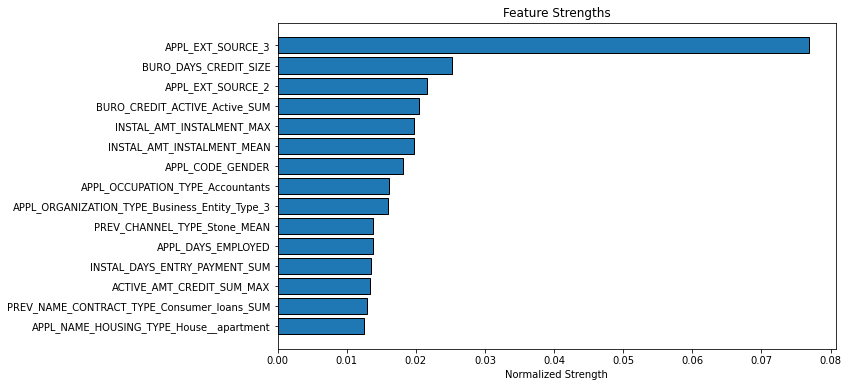

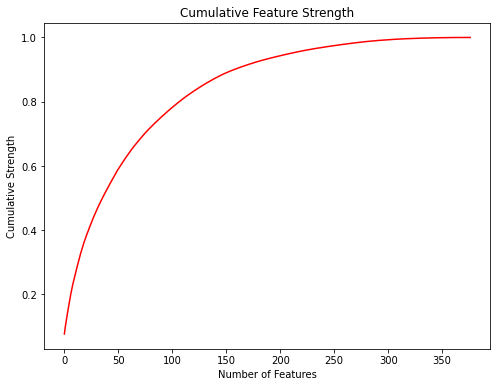

290 features required for 0.99 of cumulative strength


In [75]:
shap_coefficients=shap_values.values.mean(axis=0)[:, 1]
shap_sorted = plot_feature_importances(fi_dataframe(shap_coefficients, features), threshold = 0.99)

### 6.4.2 Détails des feature importances

In [76]:
featuretypes = set(f.split('_')[0] for f in features)

In [77]:
featuregroups = []
for featuretype in featuretypes:
    featuregroups.append({'featuretype' : featuretype, 
                          'strength' : round(100*shap_sorted[shap_sorted['feature'].str.startswith(featuretype)]['strength_norm'].sum(), 2)})
featuregroups = pd.DataFrame(featuregroups).sort_values(by='strength', ascending=False).reset_index(drop=True)
featuregroups

,featuretype,strength
0,APPL,41.32
1,PREV,27.45
2,BURO,13.17
3,INSTAL,8.01
4,ACTIVE,4.72
5,CLOSED,2.47
6,POS,1.32
7,APPROVED,1.18
8,CREDIT,0.32
9,REFUSED,0.05


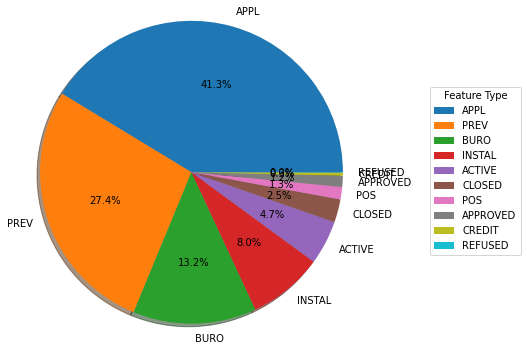

In [78]:
fig1, ax1 = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax1.pie(featuregroups['strength'], labels=featuregroups['featuretype'], autopct='%1.1f%%',
        shadow=True, startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(wedges, featuregroups['featuretype'],
          title="Feature Type",
          loc="center right",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

In [79]:
new_features = shap_sorted[shap_sorted['feature'].str.contains('_NEW_')]
print('_NEW_', 100 * new_features['strength_norm'].sum())

featuregroups = []
for featuretype in featuretypes:
    featuregroups.append({'featureytpe' : featuretype, 
                          'strength' : round(100*new_features[new_features['feature'].str.startswith(featuretype)]['strength_norm'].sum(), 2)})
featuregroups = pd.DataFrame(featuregroups).sort_values(by='strength', ascending=False).reset_index(drop=True)
featuregroups

_NEW_ 4.564884803860152


,featureytpe,strength
0,INSTAL,2.12
1,BURO,0.81
2,PREV,0.55
3,APPL,0.51
4,CLOSED,0.33
5,ACTIVE,0.14
6,APPROVED,0.11
7,REFUSED,0.00
8,POS,0.00
9,CREDIT,0.00


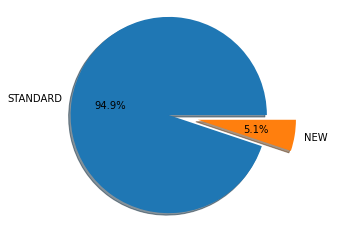

In [80]:
old_features = fi_sorted[~fi_sorted['feature'].str.contains('_NEW_')]
sizes=[old_features['strength_norm'].sum(), new_features['strength_norm'].sum()]
explode = [0, 0.3]
labels = ['STANDARD','NEW']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', normalize=True,
        shadow=True, startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [81]:
print('_NEW_', 100 * shap_sorted[shap_sorted['feature'].str.contains('_NEW_')]['strength_norm'].sum())
display(shap_sorted[shap_sorted['feature'].str.contains('_NEW_')])

_NEW_ 4.564884803860152


,feature,importance,strength,importance_norm,strength_norm,cumul_importance,cumul_strength
17,INSTAL_NEW_DBD_MEAN,-2.536439e-03,2.536439e-03,0.071639,0.010965,0.615126,0.349059
47,INSTAL_NEW_DBD_MAX,1.407748e-03,1.407748e-03,-0.039761,0.006085,0.624618,0.573628
61,BURO_NEW_DURATION_CREDIT_DAYS_MIN,1.093916e-03,1.093916e-03,-0.030897,0.004729,0.622238,0.645471
82,APPL_NEW_ANNUITY_INCOME_PERC,-7.661669e-04,7.661669e-04,0.021640,0.003312,0.844433,0.727240
111,CLOSED_NEW_DURATION_CREDIT_DAYS_MEAN,5.796206e-04,5.796206e-04,-0.016371,0.002506,1.025093,0.811894
116,PREV_NEW_APPL_CREDIT_PERC_MEAN,-5.451896e-04,5.451896e-04,0.015398,0.002357,1.007887,0.824007
127,BURO_NEW_DURATION_CREDIT_DAYS_MAX,-4.926449e-04,4.926449e-04,0.013914,0.002130,0.993017,0.848459
137,PREV_NEW_APPL_CREDIT_PERC_MAX,-4.362516e-04,4.362516e-04,0.012322,0.001886,0.941745,0.868167
163,BURO_NEW_DURATION_CREDIT_DAYS_MEAN,2.818945e-04,2.818945e-04,-0.007962,0.001219,0.968022,0.907295
165,ACTIVE_NEW_DURATION_CREDIT_DAYS_MEAN,2.673888e-04,2.673888e-04,-0.007552,0.001156,0.952686,0.909642


In [82]:
featuretype = 'APPL'
print(featuretype, 100 * shap_sorted[shap_sorted['feature'].str.startswith(featuretype)]['strength_norm'].sum())
display(shap_sorted[shap_sorted['feature'].str.startswith(featuretype)][:10])

APPL 41.32401521833634


,feature,importance,strength,importance_norm,strength_norm,cumul_importance,cumul_strength
0,APPL_EXT_SOURCE_3,-0.017787,0.017787,0.502373,0.076889,0.502373,0.076889
2,APPL_EXT_SOURCE_2,-0.004987,0.004987,0.140853,0.021558,0.808396,0.123726
6,APPL_CODE_GENDER,0.004213,0.004213,-0.118993,0.018212,0.555597,0.201928
7,APPL_OCCUPATION_TYPE_Accountants,0.003735,0.003735,-0.105504,0.016148,0.450094,0.218076
8,APPL_ORGANIZATION_TYPE_Business_Entity_Type_3,-0.003695,0.003695,0.104351,0.015971,0.554444,0.234047
10,APPL_DAYS_EMPLOYED,-0.003201,0.003201,0.090420,0.013839,0.554328,0.261742
14,APPL_NAME_HOUSING_TYPE_House__apartment,0.002908,0.002908,-0.082141,0.012572,0.386477,0.314064
15,APPL_FLAG_DOCUMENT_3,-0.002888,0.002888,0.081566,0.012484,0.468043,0.326548
18,APPL_FLAG_DOCUMENT_6,0.002535,0.002535,-0.071593,0.010957,0.543534,0.360016
19,APPL_FLAG_WORK_PHONE,-0.002252,0.002252,0.063595,0.009733,0.607128,0.369750


In [83]:
featuretype = 'INSTAL'
print(featuretype, 100 * shap_sorted[shap_sorted['feature'].str.startswith(featuretype)]['strength_norm'].sum())
display(shap_sorted[shap_sorted['feature'].str.startswith(featuretype)][:10])

INSTAL 8.007551057564385


,feature,importance,strength,importance_norm,strength_norm,cumul_importance,cumul_strength
4,INSTAL_AMT_INSTALMENT_MAX,0.004579,0.004579,-0.129322,0.019793,0.545514,0.163961
5,INSTAL_AMT_INSTALMENT_MEAN,-0.004570,0.004570,0.129077,0.019755,0.674590,0.183716
11,INSTAL_DAYS_ENTRY_PAYMENT_SUM,0.003118,0.003118,-0.088074,0.013480,0.466254,0.275222
17,INSTAL_NEW_DBD_MEAN,-0.002536,0.002536,0.071639,0.010965,0.615126,0.349059
47,INSTAL_NEW_DBD_MAX,0.001408,0.001408,-0.039761,0.006085,0.624618,0.573628
58,INSTAL_AMT_INSTALMENT_SUM,-0.001112,0.001112,0.031399,0.004806,0.653028,0.631155
193,INSTAL_DAYS_ENTRY_PAYMENT_MAX,0.000196,0.000196,-0.005524,0.000846,0.920605,0.937477
203,INSTAL_NEW_PAYMENT_PERC_MEAN,-0.000181,0.000181,0.005118,0.000783,0.930766,0.945560
220,INSTAL_NEW_PAYMENT_DIFF_SUM,-0.000155,0.000155,0.004385,0.000671,0.973922,0.957953
226,INSTAL_NEW_PAYMENT_PERC_MAX,0.000143,0.000143,-0.004036,0.000618,0.974028,0.961797


### 6.4.3 Les features le moins importantes

In [84]:
shap_sorted[-10:]

,feature,importance,strength,importance_norm,strength_norm,cumul_importance,cumul_strength
367,PREV_NAME_CLIENT_TYPE_Repeater_SUM,-2.696473e-06,2.696473e-06,0.000076,0.000012,0.999909,0.999952
368,POS_SK_DPD_DEF_MAX,-2.515381e-06,2.515381e-06,0.000071,0.000011,0.999980,0.999963
369,PREV_AMT_DOWN_PAYMENT_MIN,-2.268103e-06,2.268103e-06,0.000064,0.000010,1.000044,0.999973
370,CLOSED_CNT_CREDIT_PROLONG_SUM,2.129302e-06,2.129302e-06,-0.000060,0.000009,0.999984,0.999982
371,APPL_NAME_FAMILY_STATUS_Single__not_married,1.487380e-06,1.487380e-06,-0.000042,0.000006,0.999942,0.999989
372,INSTAL_NEW_DPD_MAX,-7.216967e-07,7.216967e-07,0.000020,0.000003,0.999962,0.999992
373,PREV_LOAN_PURPOSE_Payments_on_other_loans_SUM,-6.553716e-07,6.553716e-07,0.000019,0.000003,0.999981,0.999994
374,PREV_NAME_CONTRACT_TYPE_XNA_SUM,-6.429324e-07,6.429324e-07,0.000018,0.000003,0.999999,0.999997
375,PREV_SELLERPLACE_AREA_MEAN,-3.401573e-07,3.401573e-07,0.000010,0.000001,1.000008,0.999999
376,PREV_NAME_CONTRACT_TYPE_Revolving_loans_MEAN,2.974395e-07,2.974395e-07,-0.000008,0.000001,1.000000,1.000000


### 6.4.4 Les features importances pour des individus

# 7. Le Modèle LBGM

## 7.1 Import du Modèle

In [85]:
modelname='LGBM'
import_model = True
if import_model:
    PATH = os.path.dirname(os.getcwd()) 
    DATAFOLDER = '\\Data\\'
    modelname = modelname
    estimator = joblib.load(PATH + DATAFOLDER + modelname)

## 7.2 Import des features importances

In [86]:
filename = 'LGBM_fi.csv'
import_features = True
if import_features:
    PATH = os.path.dirname(os.getcwd()) 
    DATAFOLDER = '\\Data\\'
    fi=pd.read_csv(PATH+DATAFOLDER+filename).drop(columns=('Unnamed: 0'))

In [87]:
fi

,feature,importance
0,APPL_NAME_CONTRACT_TYPE,24.0
1,APPL_CODE_GENDER,59.4
2,APPL_FLAG_OWN_CAR,1.0
3,APPL_FLAG_OWN_REALTY,1.2
4,APPL_CNT_CHILDREN,1.2
...,...,...
372,CLOSED_AMT_CREDIT_SUM_OVERDUE_SUM,0.6
373,CLOSED_AMT_CREDIT_SUM_LIMIT_MEAN,3.8
374,CLOSED_AMT_CREDIT_SUM_LIMIT_SUM,3.8
375,CLOSED_CNT_CREDIT_PROLONG_SUM,0.2


## 7.3 Importance des Features - du coefficients

### 7.3.1 Résumé des features importances

In [88]:
features_out = fi['feature']
coefficients = fi['importance']

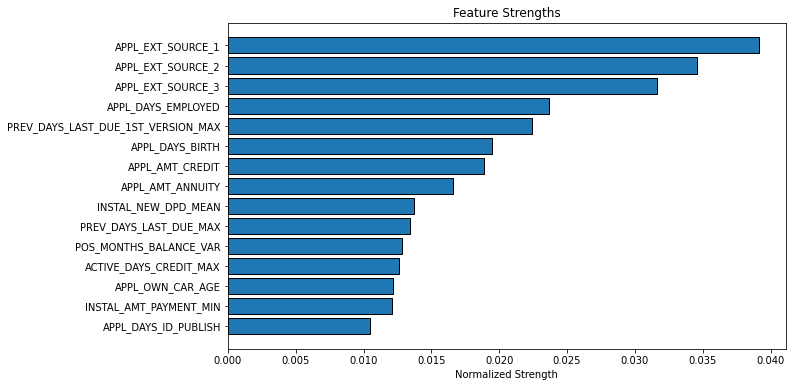

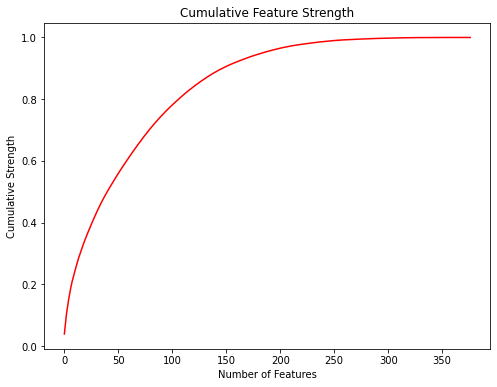

252 features required for 0.99 of cumulative strength


In [89]:
fi_sorted = plot_feature_importances(fi_dataframe(coefficients, features_out), threshold = 0.99)

### 6.3.2 Détails des feature importances

In [90]:
featuretypes = set(f.split('_')[0] for f in features)

In [91]:
featuregroups = []
for featuretype in featuretypes:
    featuregroups.append({'featuretype' : featuretype, 
                          'strength' : round(100*fi_sorted[fi_sorted['feature'].str.startswith(featuretype)]['strength_norm'].sum(), 2)})
featuregroups = pd.DataFrame(featuregroups).sort_values(by='strength', ascending=False).reset_index(drop=True)
featuregroups

,featuretype,strength
0,APPL,33.27
1,PREV,25.19
2,BURO,12.05
3,INSTAL,11.17
4,ACTIVE,7.20
5,POS,4.28
6,CLOSED,4.21
7,APPROVED,2.34
8,REFUSED,0.25
9,CREDIT,0.04


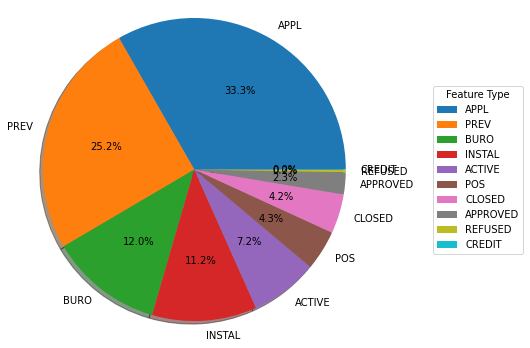

In [92]:
fig1, ax1 = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax1.pie(featuregroups['strength'], labels=featuregroups['featuretype'], autopct='%1.1f%%',
        shadow=True, startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(wedges, featuregroups['featuretype'],
          title="Feature Type",
          loc="center right",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

In [93]:
new_features = fi_sorted[fi_sorted['feature'].str.contains('_NEW_')]
print('_NEW_', 100 * new_features['strength_norm'].sum())

featuregroups = []
for featuretype in featuretypes:
    featuregroups.append({'featureytpe' : featuretype, 
                          'strength' : round(100*new_features[new_features['feature'].str.startswith(featuretype)]['strength_norm'].sum(), 2)})
featuregroups = pd.DataFrame(featuregroups).sort_values(by='strength', ascending=False).reset_index(drop=True)
featuregroups

_NEW_ 14.42028985507246


,featureytpe,strength
0,INSTAL,6.04
1,PREV,2.50
2,APPL,1.98
3,ACTIVE,1.49
4,BURO,1.23
5,CLOSED,0.82
6,APPROVED,0.36
7,REFUSED,0.00
8,POS,0.00
9,CREDIT,0.00


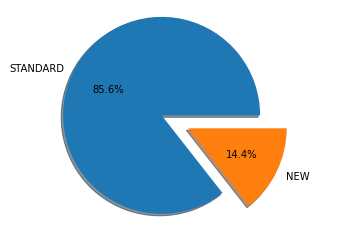

In [94]:
old_features = fi_sorted[~fi_sorted['feature'].str.contains('_NEW_')]
sizes=[old_features['strength_norm'].sum(), new_features['strength_norm'].sum()]
explode = [0, 0.3]
labels = ['STANDARD','NEW']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', normalize=True,
        shadow=True, startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [95]:
print('_NEW_', 100 * fi_sorted[fi_sorted['feature'].str.contains('_NEW_')]['strength_norm'].sum())
display(fi_sorted[fi_sorted['feature'].str.contains('_NEW_')][:10])

_NEW_ 14.42028985507246


,feature,importance,strength,importance_norm,strength_norm,cumul_importance,cumul_strength
8,INSTAL_NEW_DPD_MEAN,102.2,102.2,0.013714,0.013714,0.220048,0.220048
15,ACTIVE_NEW_DURATION_CREDIT_DAYS_MIN,77.4,77.4,0.010386,0.010386,0.303999,0.303999
23,APPL_NEW_ANNUITY_INCOME_PERC,62.8,62.8,0.008427,0.008427,0.378019,0.378019
24,PREV_NEW_APPL_CREDIT_PERC_MEAN,62.0,62.0,0.008320,0.008320,0.386339,0.386339
26,APPL_NEW_INCOME_CREDIT_PERC,60.8,60.8,0.008159,0.008159,0.402764,0.402764
31,INSTAL_NEW_PAYMENT_DIFF_MEAN,54.6,54.6,0.007327,0.007327,0.441680,0.441680
36,PREV_NEW_APPL_CREDIT_PERC_MIN,50.0,50.0,0.006710,0.006710,0.476758,0.476758
40,INSTAL_NEW_DBD_SUM,45.2,45.2,0.006065,0.006065,0.501906,0.501906
44,INSTAL_NEW_PAYMENT_DIFF_SUM,43.4,43.4,0.005824,0.005824,0.525497,0.525497
50,PREV_NEW_APPL_CREDIT_PERC_VAR,41.4,41.4,0.005556,0.005556,0.559635,0.559635


In [96]:
featuretype = 'APPL'
print(featuretype, 100 * fi_sorted[fi_sorted['feature'].str.startswith(featuretype)]['strength_norm'].sum())
display(fi_sorted[fi_sorted['feature'].str.startswith(featuretype)][:10])

APPL 33.27428878153516


,feature,importance,strength,importance_norm,strength_norm,cumul_importance,cumul_strength
0,APPL_EXT_SOURCE_1,291.8,291.8,0.039157,0.039157,0.039157,0.039157
1,APPL_EXT_SOURCE_2,257.6,257.6,0.034568,0.034568,0.073725,0.073725
2,APPL_EXT_SOURCE_3,235.6,235.6,0.031616,0.031616,0.105341,0.105341
3,APPL_DAYS_EMPLOYED,176.6,176.6,0.023698,0.023698,0.129039,0.129039
5,APPL_DAYS_BIRTH,144.8,144.8,0.019431,0.019431,0.170907,0.170907
6,APPL_AMT_CREDIT,140.4,140.4,0.018841,0.018841,0.189748,0.189748
7,APPL_AMT_ANNUITY,123.6,123.6,0.016586,0.016586,0.206334,0.206334
12,APPL_OWN_CAR_AGE,90.6,90.6,0.012158,0.012158,0.271041,0.271041
14,APPL_DAYS_ID_PUBLISH,78.2,78.2,0.010494,0.010494,0.293612,0.293612
18,APPL_DAYS_LAST_PHONE_CHANGE,74.6,74.6,0.010011,0.010011,0.334138,0.334138


In [97]:
featuretype = 'INSTAL'
print(featuretype, 100 * fi_sorted[fi_sorted['feature'].str.startswith(featuretype)]['strength_norm'].sum())
display(fi_sorted[fi_sorted['feature'].str.startswith(featuretype)][:10])

INSTAL 11.167471819645732


,feature,importance,strength,importance_norm,strength_norm,cumul_importance,cumul_strength
8,INSTAL_NEW_DPD_MEAN,102.2,102.2,0.013714,0.013714,0.220048,0.220048
13,INSTAL_AMT_PAYMENT_MIN,90.0,90.0,0.012077,0.012077,0.283119,0.283119
20,INSTAL_DAYS_ENTRY_PAYMENT_MAX,67.2,67.2,0.009018,0.009018,0.352281,0.352281
21,INSTAL_AMT_INSTALMENT_SUM,64.8,64.8,0.008696,0.008696,0.360977,0.360977
25,INSTAL_DAYS_ENTRY_PAYMENT_SUM,61.6,61.6,0.008266,0.008266,0.394605,0.394605
27,INSTAL_AMT_INSTALMENT_MAX,59.8,59.8,0.008025,0.008025,0.410789,0.410789
31,INSTAL_NEW_PAYMENT_DIFF_MEAN,54.6,54.6,0.007327,0.007327,0.441680,0.441680
40,INSTAL_NEW_DBD_SUM,45.2,45.2,0.006065,0.006065,0.501906,0.501906
44,INSTAL_NEW_PAYMENT_DIFF_SUM,43.4,43.4,0.005824,0.005824,0.525497,0.525497
58,INSTAL_AMT_INSTALMENT_MEAN,38.6,38.6,0.005180,0.005180,0.602093,0.602093


### 7.3.3 Les features le moins importantes

In [98]:
fi_sorted[-10:]

,feature,importance,strength,importance_norm,strength_norm,cumul_importance,cumul_strength
367,POS_NAME_CONTRACT_STATUS_Demand_SUM,0.0,0.0,0.0,0.0,1.0,1.0
368,POS_NAME_CONTRACT_STATUS_Returned_to_the_store...,0.0,0.0,0.0,0.0,1.0,1.0
369,APPL_ORGANIZATION_TYPE_Trade_type_7,0.0,0.0,0.0,0.0,1.0,1.0
370,APPL_ORGANIZATION_TYPE_Industry_type_3,0.0,0.0,0.0,0.0,1.0,1.0
371,APPL_NAME_TYPE_SUITE_Other,0.0,0.0,0.0,0.0,1.0,1.0
372,BURO_CREDIT_TYPE_Another_type_of_loan_SUM,0.0,0.0,0.0,0.0,1.0,1.0
373,BURO_CREDIT_TYPE_Loan_for_business_development...,0.0,0.0,0.0,0.0,1.0,1.0
374,APPL_AMT_REQ_CREDIT_BUREAU_DAY,0.0,0.0,0.0,0.0,1.0,1.0
375,BURO_CREDIT_TYPE_Unknown_type_of_loan_SUM,0.0,0.0,0.0,0.0,1.0,1.0
376,PREV_NAME_PRODUCT_TYPE_POS_others_without_inte...,0.0,0.0,0.0,0.0,1.0,1.0


## 7.4 Importance des Features - avec SHAP

### 7.4.0 Créations des SHAP valeurs

In [100]:
explainer = shap.Explainer(estimator.predict_proba, X)

In [101]:
export_explainer = True
if export_explainer:
    PATH = os.path.dirname(os.getcwd())
    DATAFOLDER = '\\Data\\'
    with open(PATH + DATAFOLDER + modelname+'_SHAP', "wb") as e:
        explainer.save(e)

In [102]:
shap_values = explainer(X_min, max_evals=2000)

Permutation explainer: 6151it [1:58:36,  1.16s/it]                                                                     


In [312]:
shap_values = explainer(X_min_min, max_evals=2000)

Permutation explainer: 616it [12:11,  1.21s/it]                                                                        


In [313]:
modelname

'LGBM'

In [314]:
export_shap_values = True
if export_shap_values:
    PATH = os.path.dirname(os.getcwd()) 
    DATAFOLDER = '\\Data\\'
    filename = modelname + '_SHAPvalues_min_min'
    joblib.dump(shap_values, PATH + DATAFOLDER + filename)    
    #pd.DataFrame(shap_values).to_csv(PATH + DATAFOLDER + filename + '.csv')

In [280]:
import_shap_values = True
if import_shap_values:
    PATH = os.path.dirname(os.getcwd()) 
    DATAFOLDER = '\\Data\\'
    filename = modelname + '_SHAPvalues_min'
    shap_values = joblib.load(PATH + DATAFOLDER + filename)
    #pd.DataFrame(shap_values).to_csv(PATH + DATAFOLDER + filename + '.csv')

In [281]:
gc.collect()

926

In [282]:
shap_values.base_values[:,1]

array([0.4258289, 0.4258289, 0.4258289, ..., 0.4258289, 0.4258289,
       0.4258289])

### 7.4.1 Résumé des features importances

In [283]:
shap_values_adj = shap_values
shap_values_adj.values = shap_values.values[:,:,1]
shap_values_adj.base_values = shap_values.base_values[:, 1]

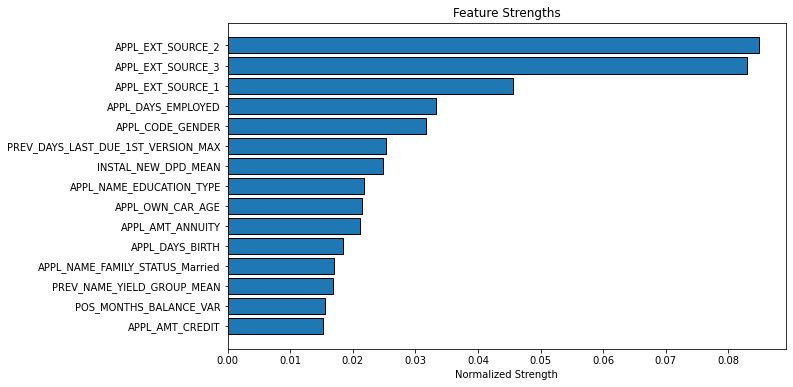

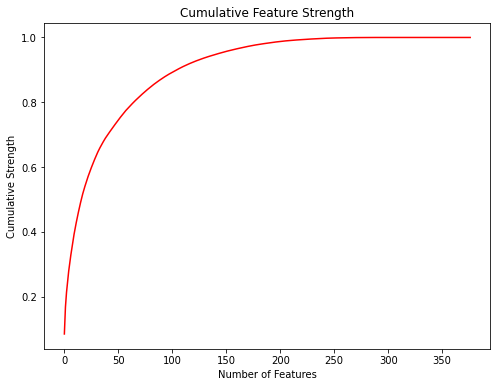

208 features required for 0.99 of cumulative strength


In [208]:
shap_coefficients=abs(shap_values.values).mean(axis=0)
shap_sorted = plot_feature_importances(fi_dataframe(shap_coefficients, features), threshold = 0.99)

In [200]:
shap_values.values.shape

(6150, 377)

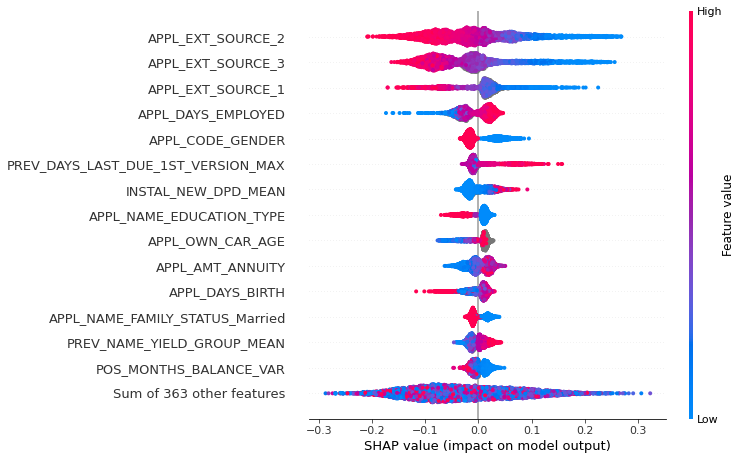

In [201]:
#shap.plots.beeswarm(shap_values_adj, order=shap_values.abs.mean(0), max_display=15)

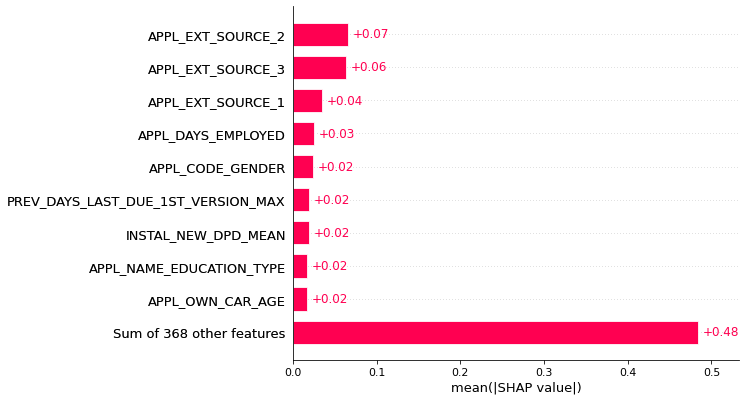

In [216]:
shap.plots.bar(shap_values.abs.mean(0))

In [251]:
shap_values

.values =
array([[ 1.32296028e-03, -1.39648123e-02, -6.02459783e-05, ...,
         0.00000000e+00,  0.00000000e+00, -1.23587749e-04],
       [ 1.22644728e-03, -2.52164515e-02, -5.14713813e-05, ...,
         0.00000000e+00,  0.00000000e+00,  1.73241873e-04],
       [ 1.85340286e-03,  3.26641773e-02,  0.00000000e+00, ...,
         0.00000000e+00,  0.00000000e+00,  6.98312509e-08],
       ...,
       [ 7.72986476e-04, -2.03202296e-02,  7.32332365e-05, ...,
         0.00000000e+00,  0.00000000e+00,  2.79287115e-05],
       [-2.05098471e-02, -1.70622218e-02, -1.57588104e-06, ...,
         0.00000000e+00,  0.00000000e+00,  9.04748071e-05],
       [ 1.58618692e-03, -1.92466411e-02,  1.04960610e-04, ...,
         0.00000000e+00,  0.00000000e+00, -7.67577736e-05]])

.base_values =
array([[0.5741711, 0.4258289],
       [0.5741711, 0.4258289],
       [0.5741711, 0.4258289],
       ...,
       [0.5741711, 0.4258289],
       [0.5741711, 0.4258289],
       [0.5741711, 0.4258289]])

.data =
array([[ 

### 7.4.2 Détails des feature importances

In [106]:
featuretypes = set(f.split('_')[0] for f in features)

In [107]:
featuregroups = []
for featuretype in featuretypes:
    featuregroups.append({'featuretype' : featuretype, 
                          'strength' : round(100*shap_sorted[shap_sorted['feature'].str.startswith(featuretype)]['strength_norm'].sum(), 2)})
featuregroups = pd.DataFrame(featuregroups).sort_values(by='strength', ascending=False).reset_index(drop=True)
featuregroups

,featuretype,strength
0,APPL,56.40
1,PREV,20.16
2,BURO,8.64
3,INSTAL,5.87
4,ACTIVE,3.93
5,APPROVED,1.83
6,POS,1.82
7,CLOSED,1.34
8,REFUSED,0.01
9,CREDIT,0.00


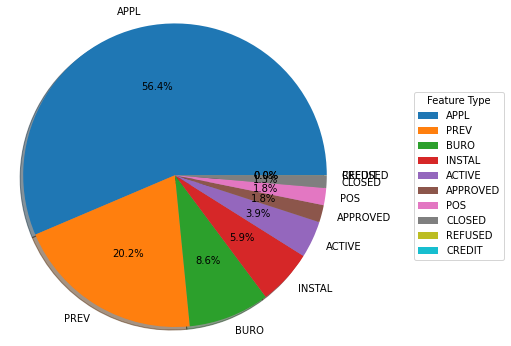

In [108]:
fig1, ax1 = plt.subplots(figsize=(6,6))
wedges, texts, autotexts = ax1.pie(featuregroups['strength'], labels=featuregroups['featuretype'], autopct='%1.1f%%',
        shadow=True, startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
ax1.legend(wedges, featuregroups['featuretype'],
          title="Feature Type",
          loc="center right",
          bbox_to_anchor=(1, 0, 0.5, 1))
plt.show()

In [109]:
new_features = shap_sorted[shap_sorted['feature'].str.contains('_NEW_')]
print('_NEW_', 100 * new_features['strength_norm'].sum())

featuregroups = []
for featuretype in featuretypes:
    featuregroups.append({'featureytpe' : featuretype, 
                          'strength' : round(100*new_features[new_features['feature'].str.startswith(featuretype)]['strength_norm'].sum(), 2)})
featuregroups = pd.DataFrame(featuregroups).sort_values(by='strength', ascending=False).reset_index(drop=True)
featuregroups

_NEW_ 5.73147070097164


,featureytpe,strength
0,INSTAL,2.48
1,PREV,1.48
2,BURO,0.58
3,ACTIVE,0.48
4,APPL,0.46
5,CLOSED,0.24
6,APPROVED,0.01
7,REFUSED,0.00
8,POS,0.00
9,CREDIT,0.00


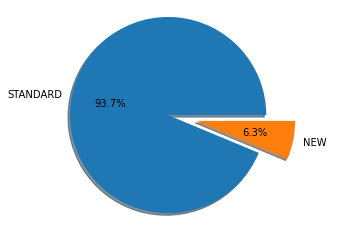

In [110]:
old_features = fi_sorted[~fi_sorted['feature'].str.contains('_NEW_')]
sizes=[old_features['strength_norm'].sum(), new_features['strength_norm'].sum()]
explode = [0, 0.3]
labels = ['STANDARD','NEW']
fig1, ax1 = plt.subplots()
ax1.pie(sizes, explode=explode, labels=labels, autopct='%1.1f%%', normalize=True,
        shadow=True, startangle=0)
ax1.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

In [111]:
print('_NEW_', 100 * shap_sorted[shap_sorted['feature'].str.contains('_NEW_')]['strength_norm'].sum())
display(shap_sorted[shap_sorted['feature'].str.contains('_NEW_')])

_NEW_ 5.73147070097164


,feature,importance,strength,importance_norm,strength_norm,cumul_importance,cumul_strength
17,INSTAL_NEW_PAYMENT_DIFF_MEAN,-0.000955,0.000955,0.018195,0.009712,0.767577,0.586224
38,PREV_NEW_APPL_CREDIT_PERC_MAX,-0.000566,0.000566,0.010778,0.005753,0.852127,0.742555
51,PREV_NEW_APPL_CREDIT_PERC_MIN,-0.000376,0.000376,0.007171,0.003828,0.908750,0.797949
58,PREV_NEW_APPL_CREDIT_PERC_MEAN,-0.000355,0.000355,0.006758,0.003607,0.942996,0.823659
59,ACTIVE_NEW_DURATION_CREDIT_DAYS_MIN,-0.000338,0.000338,0.006444,0.003440,0.949440,0.827099
61,INSTAL_NEW_PAYMENT_DIFF_SUM,-0.000317,0.000317,0.006043,0.003226,0.961838,0.833717
66,APPL_NEW_INCOME_PER_PERSON,0.000276,0.000276,-0.005265,0.002810,0.945295,0.848303
67,INSTAL_NEW_DBD_SUM,-0.000272,0.000272,0.005187,0.002768,0.950482,0.851071
70,BURO_NEW_DURATION_CREDIT_DAYS_MAX,0.000267,0.000267,-0.005088,0.002716,0.955629,0.859250
75,BURO_NEW_DURATION_CREDIT_DAYS_MEAN,0.000234,0.000234,-0.004450,0.002375,0.951144,0.871750


In [112]:
featuretype = 'APPL'
print(featuretype, 100 * shap_sorted[shap_sorted['feature'].str.startswith(featuretype)]['strength_norm'].sum())
display(shap_sorted[shap_sorted['feature'].str.startswith(featuretype)][:10])

APPL 56.39706867332318


,feature,importance,strength,importance_norm,strength_norm,cumul_importance,cumul_strength
0,APPL_EXT_SOURCE_3,-0.022160,0.022160,0.422331,0.225430,0.422331,0.225430
1,APPL_DAYS_EMPLOYED,-0.006056,0.006056,0.115424,0.061610,0.537754,0.287040
2,APPL_EXT_SOURCE_2,-0.005141,0.005141,0.097975,0.052297,0.635730,0.339337
4,APPL_EXT_SOURCE_1,0.002741,0.002741,-0.052246,0.027888,0.513189,0.404746
5,APPL_AMT_CREDIT,-0.002556,0.002556,0.048704,0.025997,0.561893,0.430743
6,APPL_CODE_GENDER,0.002246,0.002246,-0.042800,0.022846,0.519092,0.453589
12,APPL_FLOORSMAX_AVG,-0.001134,0.001134,0.021616,0.011538,0.669923,0.534098
13,APPL_NAME_INCOME_TYPE_State_servant,-0.001062,0.001062,0.020240,0.010804,0.690163,0.544902
19,APPL_DAYS_BIRTH,-0.000880,0.000880,0.016769,0.008951,0.766489,0.604707
20,APPL_NAME_EDUCATION_TYPE,0.000878,0.000878,-0.016729,0.008929,0.749760,0.613636


In [113]:
featuretype = 'INSTAL'
print(featuretype, 100 * shap_sorted[shap_sorted['feature'].str.startswith(featuretype)]['strength_norm'].sum())
display(shap_sorted[shap_sorted['feature'].str.startswith(featuretype)][:10])

INSTAL 5.86927456734418


,feature,importance,strength,importance_norm,strength_norm,cumul_importance,cumul_strength
16,INSTAL_AMT_PAYMENT_MIN,-0.001009,0.001009,0.019236,0.010267,0.749382,0.576512
17,INSTAL_NEW_PAYMENT_DIFF_MEAN,-0.000955,0.000955,0.018195,0.009712,0.767577,0.586224
27,INSTAL_DAYS_ENTRY_PAYMENT_SUM,0.000745,0.000745,-0.014192,0.007575,0.797897,0.671108
34,INSTAL_AMT_INSTALMENT_SUM,-0.000616,0.000616,0.011742,0.006268,0.807047,0.718492
35,INSTAL_AMT_INSTALMENT_MEAN,-0.000616,0.000616,0.011734,0.006263,0.818781,0.724756
61,INSTAL_NEW_PAYMENT_DIFF_SUM,-0.000317,0.000317,0.006043,0.003226,0.961838,0.833717
67,INSTAL_NEW_DBD_SUM,-0.000272,0.000272,0.005187,0.002768,0.950482,0.851071
76,INSTAL_NEW_DBD_MEAN,-0.000210,0.000210,0.004011,0.002141,0.955155,0.873891
84,INSTAL_DAYS_ENTRY_PAYMENT_MAX,0.000188,0.000188,-0.003592,0.001917,0.962700,0.890185
95,INSTAL_AMT_INSTALMENT_MAX,0.000153,0.000153,-0.002909,0.001553,0.959474,0.908767


### 7.4.3 Les features le moins importantes

In [114]:
shap_sorted[-10:]

,feature,importance,strength,importance_norm,strength_norm,cumul_importance,cumul_strength
367,APPL_ORGANIZATION_TYPE_Trade_type_3,0.0,0.0,-0.0,0.0,1.0,1.0
368,POS_NAME_CONTRACT_STATUS_Approved_SUM,0.0,0.0,-0.0,0.0,1.0,1.0
369,APPL_ORGANIZATION_TYPE_Trade_type_7,0.0,0.0,-0.0,0.0,1.0,1.0
370,APPL_ORGANIZATION_TYPE_Transport_type_4,0.0,0.0,-0.0,0.0,1.0,1.0
371,APPL_FONDKAPREMONT_MODE_org_spec_account,0.0,0.0,-0.0,0.0,1.0,1.0
372,APPL_FONDKAPREMONT_MODE_reg_oper_spec_account,0.0,0.0,-0.0,0.0,1.0,1.0
373,BURO_CREDIT_DAY_OVERDUE_MEAN,0.0,0.0,-0.0,0.0,1.0,1.0
374,APPL_WALLSMATERIAL_MODE_Block,0.0,0.0,-0.0,0.0,1.0,1.0
375,APPL_WALLSMATERIAL_MODE_Wooden,0.0,0.0,-0.0,0.0,1.0,1.0
376,PREV_NAME_PRODUCT_TYPE_POS_others_without_inte...,0.0,0.0,-0.0,0.0,1.0,1.0


### 7.4.4 Les features importances pour des individus

In [220]:
client_id = 128376
client_id = 100577
client_ids_min[client_ids_min == int(client_id)]

4288    100577
Name: SK_ID_CURR, dtype: int64

In [237]:
#shap_value = shap_values.values[client_ids_min[client_ids_min == int(client_id)].index.values[0]]
#base_value = shap_values.base_values[client_ids_min[client_ids_min == int(client_id)].index.values[0]]
#data_value = shap_values.data[client_ids_min[client_ids_min == int(client_id)].index.values[0]]

In [292]:
import random

In [302]:
#client_ids_min[y_min == 0].values

array([191120, 292757, 232695, ..., 369307, 137516, 446421], dtype=int64)

In [309]:
client_id = random.choice(client_ids_min[y_min == 1].values)
client_id

240790

In [310]:
ii = int(client_ids_min[client_ids_min == int(client_id)].index.values[0])
shap_value = shap_values[ii]
y_min[ii]

1

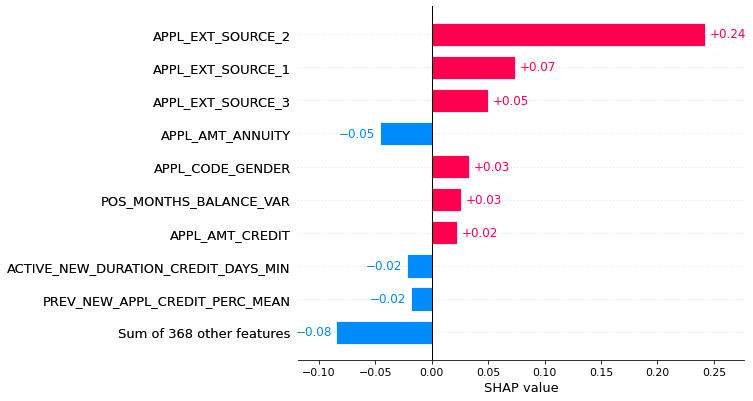

In [311]:
shap.plots.bar(shap_value)

In [262]:
shap.plots.waterfall(shap_value)

AttributeError: 'numpy.ndarray' object has no attribute 'base_values'

In [ ]:
shap_value = explainer(X_min[client_ids_min == int(client_id)], max_evals=5000)[0]

In [124]:
shap_value.values

array([[-5.64342173e-04,  5.64342173e-04],
       [ 1.65723811e-02, -1.65723811e-02],
       [-2.30885688e-05,  2.30885688e-05],
       [-1.15301643e-03,  1.15301643e-03],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 1.70677868e-04, -1.70677868e-04],
       [-1.32655817e-02,  1.32655817e-02],
       [ 1.12969234e-02, -1.12969234e-02],
       [-3.61580293e-03,  3.61580293e-03],
       [ 1.87387945e-02, -1.87387945e-02],
       [ 2.31573129e-02, -2.31573129e-02],
       [ 9.25995531e-03, -9.25995531e-03],
       [ 6.70392552e-03, -6.70392552e-03],
       [-9.34206994e-03,  9.34206994e-03],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 6.23263715e-04, -6.23263715e-04],
       [ 7.04889447e-04, -7.04889447e-04],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 3.01915768e-04, -3.01915768e-04],
       [ 1.32838927e-03, -1.32838927e-03],
       [-4.26233223e-04,  4.26233223e-04],
       [-3.00854454e-07,  3.00854454e-07],
       [ 0.00000000e+00,  0.00000000e+00],
       [ 0.

In [219]:
shap_value = explainer(X_min[client_ids_min == int(client_id)], max_evals=5000)[0]
shap_data = pd.DataFrame(np.array([abs(shap_value.values[:,1]), shap_value.values[:,1], shap_value.data.round(3)]).T, 
                                  index=shap_values.feature_names, 
                                  columns=["SHAP_Strength","SHAP", "Data"])
shap_data.sort_values(by="SHAP_Strength", ascending=False)[:5]

,SHAP_Strength,SHAP,Data
APPL_EXT_SOURCE_3,0.067406,-0.067406,0.651
APPL_EXT_SOURCE_2,0.033798,-0.033798,0.637
APPL_DAYS_EMPLOYED,0.022212,-0.022212,NaN
APPL_DAYS_BIRTH,0.018799,-0.018799,-23169.000
APPL_CODE_GENDER,0.015046,-0.015046,1.000


In [218]:
shap_value = shap_values[client_ids_min[client_ids_min == int(client_id)].index.values[0]]

shap_data = pd.DataFrame(np.array([abs(shap_value.values), shap_value.values, shap_value.data.round(3)]).T, 
                                  index=shap_values.feature_names, 
                                  columns=["SHAP_Strength","SHAP", "Data"])
shap_data.sort_values(by="SHAP_Strength", ascending=False)[:5]

,SHAP_Strength,SHAP,Data
APPL_EXT_SOURCE_3,0.066781,-0.066781,0.651
APPL_EXT_SOURCE_2,0.027885,-0.027885,0.637
APPL_DAYS_EMPLOYED,0.024251,-0.024251,NaN
APPL_DAYS_BIRTH,0.023220,-0.023220,-23169.000
APPL_CODE_GENDER,0.017477,-0.017477,1.000
